In [1]:
from __future__ import division
import sys
sys.path.append('../src')
import params
import numpy as np
import os
from tqdm import tqdm

model_folder = '../models/'

model_filename = '1472001110_stacked/1472001110_stacked_epoch224.npz'
model_path = os.path.join(model_folder, model_filename)

params.params = params.Params(['../config/default.ini'] + 
                              ['../config/stacked.ini', '../config/titania_stacked.ini'])
from params import params as P
import theano
import theano.tensor as T
import lasagne
import resnet
reload(resnet)

import patch_sampling
from cparallel import ContinuousParallelBatchIterator



Loaded configurations from (in order) ['../src/../config/default.ini', '../src/../config/notebook.ini']
Loaded configurations from (in order) ['../config/default.ini', '../config/stacked.ini', '../config/titania_stacked.ini']
Couldn't import dot_parser, loading of dot files will not be possible.
OpenCV 2 NOT AVAILABLE, using skimage/scipy.ndimage instead


Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:

train_generator, validation_generator, train_sampler, validation_sampler = (
    
    patch_sampling.prepare_custom_sampler(mini_subset=False, override_cache_size=1, return_samplers=True)

)

Loading train samplers
Loading validation samplers
Loading samplers took 45.6522037983 seconds.


In [3]:
# DEFINE AND LOAD NETWORK

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

net = resnet.ResNet_FullPre_Wide(input_var, 4, 2)
all_layers = lasagne.layers.get_all_layers(net)
net = all_layers[-3]
net = resnet.ResNet_Stacked_Old(net)

with np.load(model_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

lasagne.layers.set_all_param_values(net, param_values)

In [4]:
predict_fn = resnet.define_predict(net, input_var, target_var)

In [5]:
batch_size = 20
X = [batch_size]*1000

batch_gen = ContinuousParallelBatchIterator(validation_generator, 
                                            ordered=False, batch_size=1, multiprocess=False, n_producers=3)
batch_gen.append(X)

In [6]:
all_inputs = []
all_targets = []
all_filenames = []

all_loss = []
all_pred = []
all_binary_pred = []

In [7]:
for i, batch in enumerate(tqdm(batch_gen(50))):
    inputs, targets, filenames = batch
    
    loss, acc, pred_binary, pred = predict_fn(inputs, targets)
    
    for x in range(len(inputs)):
        
        filename = filenames[x]
        target = targets[x]
        p = pred[x]
        p_binary = pred_binary[x]
        l = loss[x]
        
        #all_inputs.append(inputs[x].astype(np.float16))
        all_targets.append(target)
        all_filenames.append(filename)
        all_pred.append(p)
        all_binary_pred.append(p_binary)
        all_loss.append(l)
            
    del inputs

100%|██████████| 50/50 [09:58<00:00, 11.02s/it]


In [8]:
file_loss = {}
file_count = {}
file_target = {}

for filename, target, prediction, prediction_binary, loss in zip(all_filenames, all_targets, all_pred, all_binary_pred, all_loss):
    
    if filename not in file_loss:
        file_loss[filename] = 0
        file_count[filename] = 0
        
    file_loss[filename] += loss
    file_count[filename] += 1
    file_target[filename] = target


In [9]:
# Average loss per file
file_avg_loss = {f:file_loss[f]/file_count[f] for f in np.unique(filenames)}
import operator
file_loss_tups = file_avg_loss.iteritems()
# Sort by loss
file_loss_tups = list(reversed(sorted(file_loss_tups, key=operator.itemgetter(1))))


In [10]:
import util
misclassified = np.array(all_binary_pred) != np.array(all_targets)
print "Amount of wrong labels", np.sum(misclassified), "out of", len(all_targets)

Amount of wrong labels 111 out of 1000


In [11]:
sampler_of_filename = {}

all_samplers = []
for x in validation_sampler.per_label_sampler_list.values():
    print len(x)
    all_samplers += x

    
i = 0
for sampler in all_samplers:
    
    i += 1
    #print sampler.filename
    sampler_of_filename[sampler.filename] = sampler

795
151
432


In [55]:
PATCH_SIZE=768
BATCH_SIZE=32
import util

def classify_roi(sampler):
    im = sampler.sample_full()
    
    
    
    # Positions at which a patch is extracted
    positions = [(x,y) for x in range(256, im.shape[1]-PATCH_SIZE-256+1, PATCH_SIZE) for y in xrange(256, im.shape[2]-PATCH_SIZE-256+1, PATCH_SIZE)]    

    batches = list(util.chunks(positions, BATCH_SIZE))
    im_batches = map(lambda b: [im[:,x:x+PATCH_SIZE,y:y+PATCH_SIZE] for (x,y) in b], batches)
    
    #for b in im_batches:
    #    for x in b:
    #        print x.shape
    
    all_preds = []
    
    for b in im_batches:
        images = np.array(b, dtype=np.float32)
        images = util.normalize_image(images)
        images = util.zero_center(images, P.MEAN_PIXEL)
        fake_labels = np.array([-1]*len(images), dtype=np.int32)
        _, _, pred_binary, pred = predict_fn(images, fake_labels)
        
        all_preds+= list(pred_binary)
    
    return max(all_preds)


    

100%|██████████| 20/20 [01:11<00:00,  4.01s/it]


In [60]:
actual_labels = [0]*300 + [1]*150 + [2]*150

pred_labels = []


# Benign label
for s in tqdm(np.random.choice(validation_sampler.per_label_sampler_list[1], 300, replace=False)):
    roi_label = classify_roi(s)
    pred_labels.append(roi_label)
    
# DCIS
for s in tqdm(np.random.choice(validation_sampler.per_label_sampler_list[2], 150, replace=False)):
    roi_label = classify_roi(s)
    pred_labels.append(roi_label)

# IDC
for s in tqdm(np.random.choice(validation_sampler.per_label_sampler_list[3], 150, replace=False)):
    roi_label = classify_roi(s)
    pred_labels.append(roi_label)
    


100%|██████████| 150/150 [07:37<00:00,  3.66s/it]


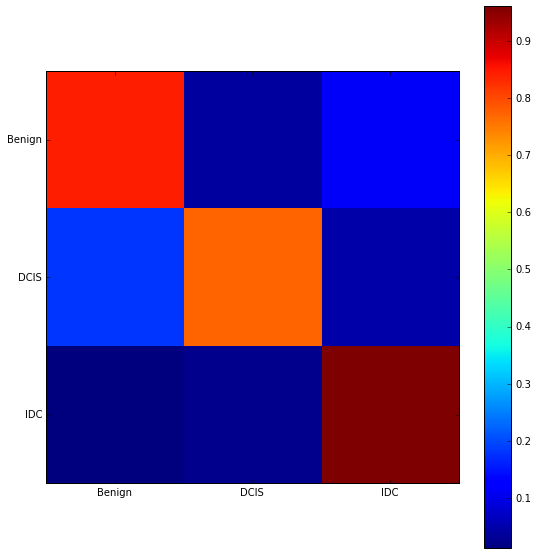

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(actual_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label_names = ['Benign', 'DCIS', 'IDC']

plt.figure(figsize=(8,8))
plt.imshow(cm_normalized, interpolation='nearest')
plt.xticks(np.arange(0,3), label_names)
plt.yticks(np.arange(0,3), label_names)
plt.tight_layout()
plt.colorbar()
plt.show()

In [62]:
# From https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[7]) # 7 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}.3f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print 
    
print_cm(cm_normalized, label_names)

             Benign    DCIS     IDC
     Benign   0.843   0.040   0.117
       DCIS   0.180   0.773   0.047
        IDC   0.013   0.027   0.960


In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

PATCH_SIZE = 768

im_filename = file_loss_tups[2][0]
sampler = sampler_of_filename[im_filename]
im = sampler.sample_full()
truth_cropped = sampler.mask.image
truth = np.zeros(im.shape[1:])

off0 = sampler.mask.offset[0] + PATCH_SIZE//2
off1 = sampler.mask.offset[1] + PATCH_SIZE//2


truth[off0:off0+sampler.mask.image.shape[0], off1:off1+sampler.mask.image.shape[1]] = truth_cropped

print im_filename

/mnt/diskA/guido/Level1_LargePatch_Aug17/Original/Validation/Label1/T10-20193_mixV1_cropped_28.jpeg


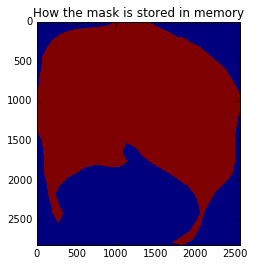

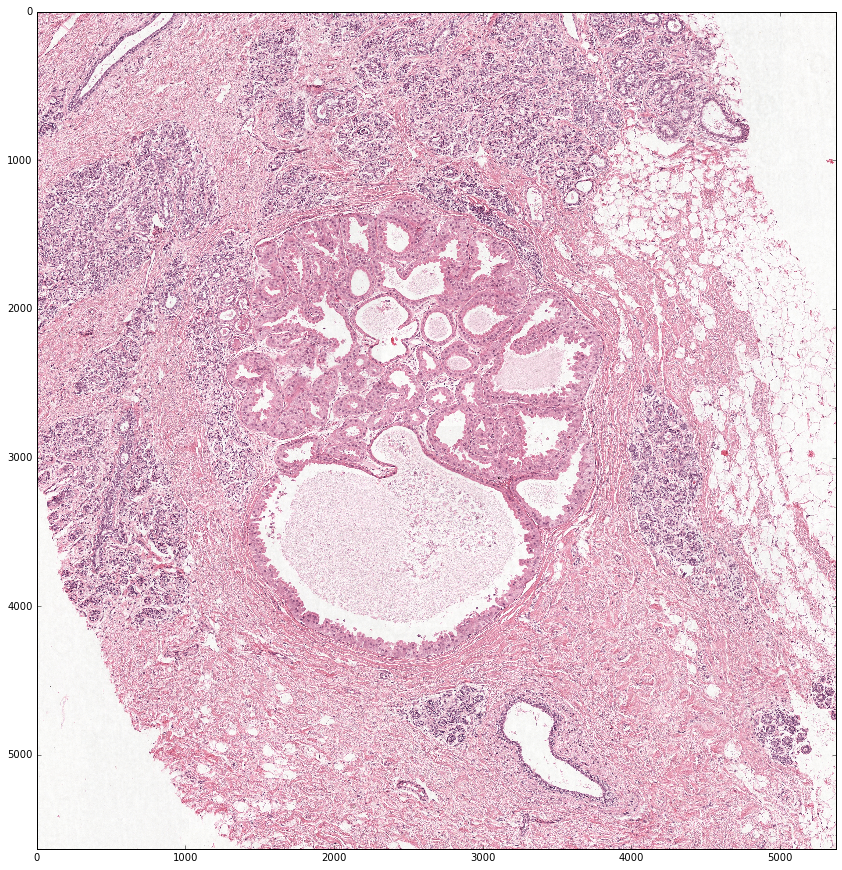

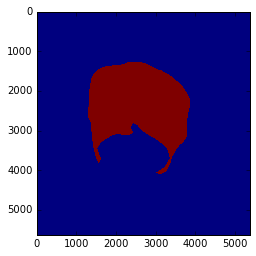

Labels in image  ['DCIS']


In [71]:
plt.imshow(truth_cropped)
plt.title("How the mask is stored in memory")
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(im.transpose(1,2,0))
plt.show()
plt.imshow(truth)
plt.show()
from dataset import label_name
print "Labels in image ", map(label_name, sampler.labels)


100%|██████████| 8/8 [00:11<00:00,  1.25s/it]


(5632, 5376)
(3, 5632, 5376)


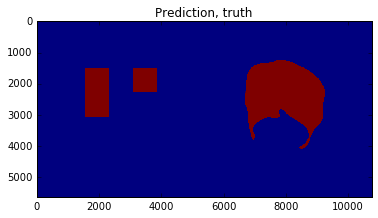

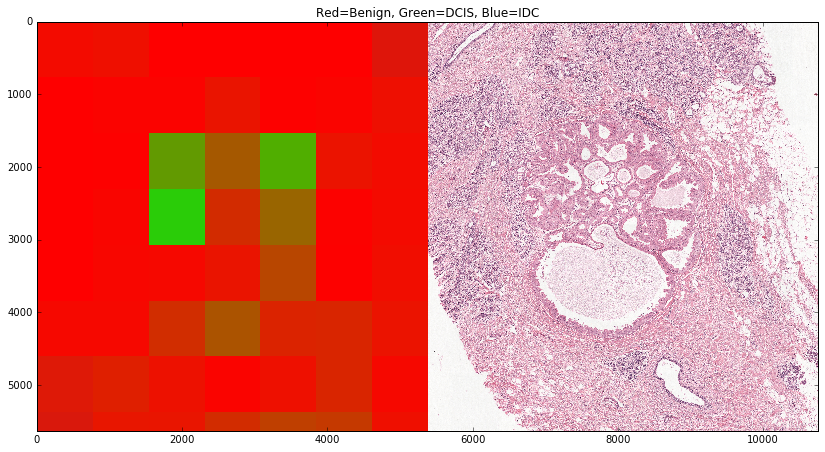

In [72]:
im_prediction = np.zeros(im.shape[1:])
im_prediction_three = np.zeros(im.shape[1:]+(3,))


for x in tqdm(xrange(0, im.shape[1], PATCH_SIZE)):
    
    y_imgs = []
    
    for y in xrange(0, im.shape[2], PATCH_SIZE):
        sub_image = im[:,x:x+PATCH_SIZE, y:y+PATCH_SIZE]
        sub_image = util.normalize_image(sub_image)
        sub_image = util.zero_center(np.array([sub_image], dtype=np.float32), P.MEAN_PIXEL)
        _, _, pred_binary, pred = predict_fn(sub_image, np.array([-1], dtype=np.int32))
        im_prediction[x:x+PATCH_SIZE, y:y+PATCH_SIZE] = pred_binary #sub_image[0,0,:,:]
        im_prediction_three[x:x+PATCH_SIZE, y:y+PATCH_SIZE] = pred
        
print im_prediction.shape
print im.shape
plt.title("Prediction, truth")
plt.imshow(np.hstack((im_prediction, truth)))
plt.show()


original = im.transpose(1,2,0)

plt.figure(figsize=(14,14))
plt.title("Red=Benign, Green=DCIS, Blue=IDC")
plt.imshow(np.hstack((im_prediction_three, util.normalize_image(original))))
        

In [73]:
wrong_images = []

for (f, l) in tqdm(file_loss_tups[:18]):
    im = sampler_of_filename[f].sample_full()
    im = util.normalize_image(im)
    wrong_images.append(im)

100%|██████████| 18/18 [00:19<00:00,  1.59s/it]


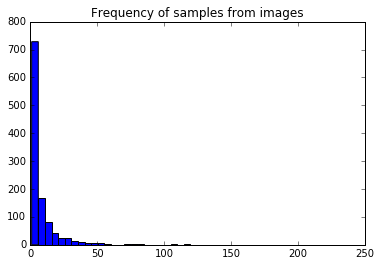

/mnt/diskA/guido/Level1_LargePatch_Aug17/Original/Validation/Label2/T11-15708-I-4-1V2_cropped_3.jpeg
248


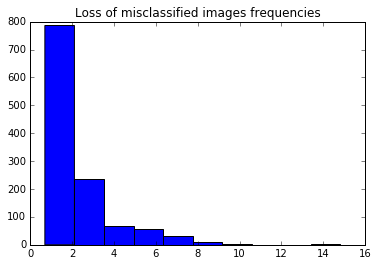

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(file_count.values(), 50)
plt.title("Frequency of samples from images")
plt.show()

print all_filenames[np.argmax(file_count.values())]
print np.max(file_count.values())

plt.hist(np.array(all_loss)[misclassified], 10)
plt.title("Loss of misclassified images frequencies")
plt.show()




## Predictions that are most wrong
(Number in the title of the images is the loss of that prediction)

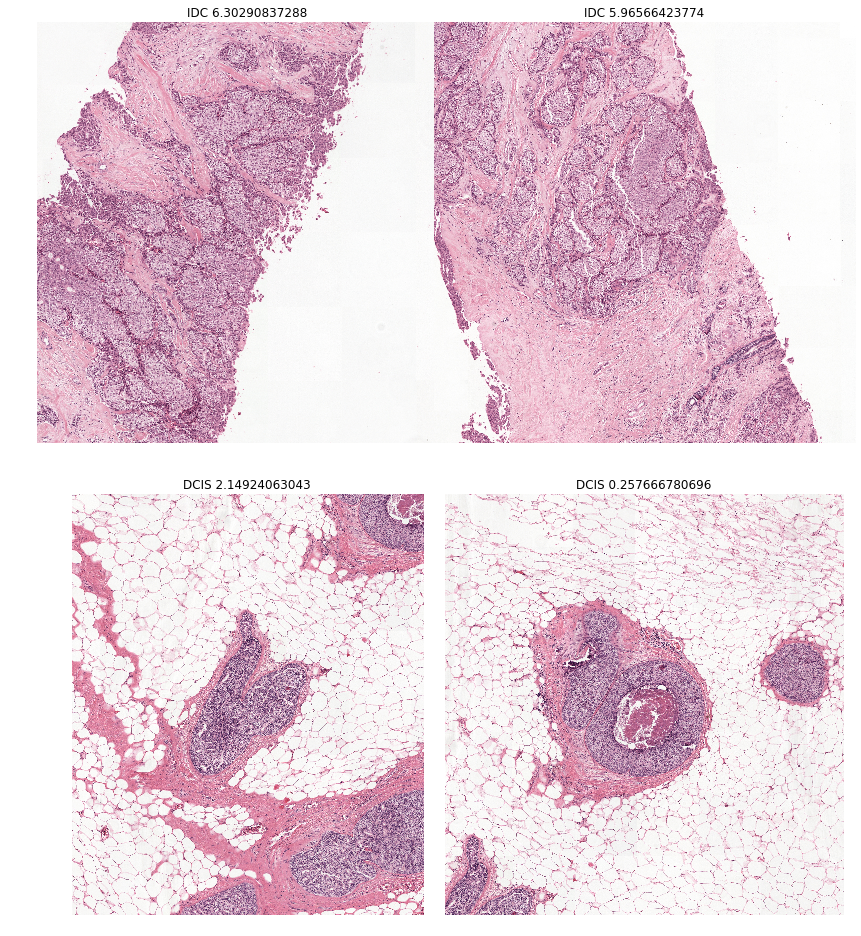

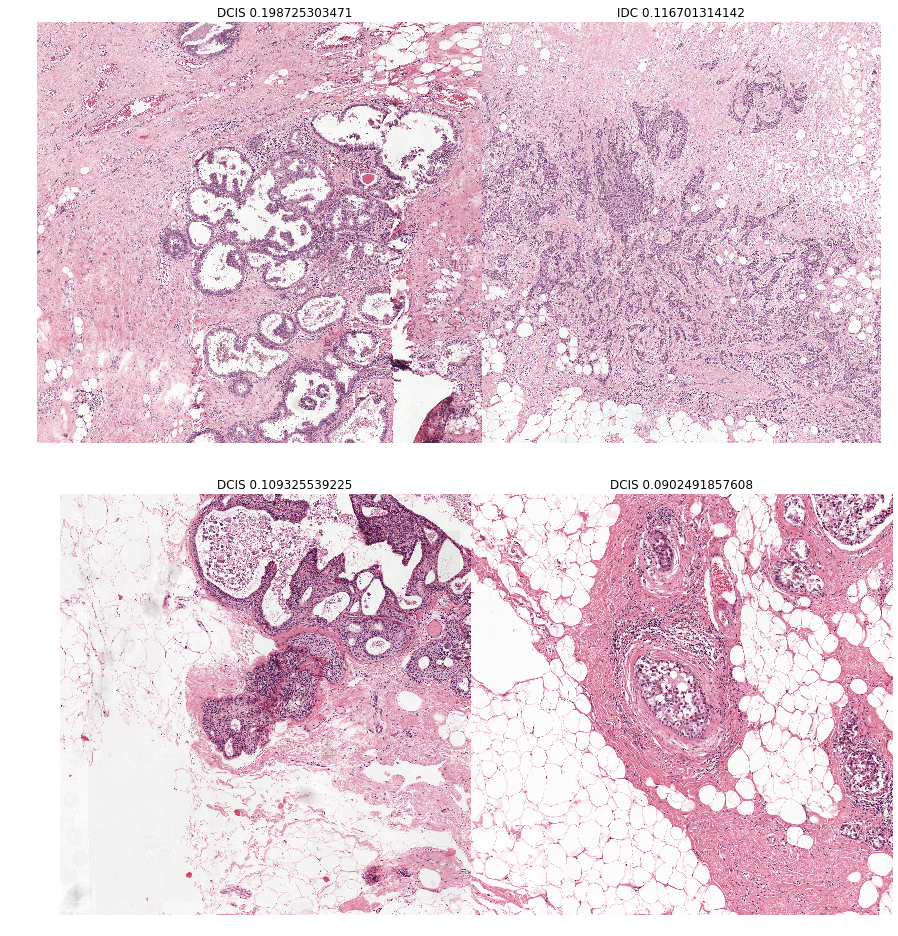

In [87]:
%matplotlib inline


import matplotlib.pyplot as plt
import util
from dataset import label_name


#For N by N plots
N = 2


for plot_number in range(0, len(wrong_images), N**2):
    
    if plot_number//N**2 >= 2: #Lets not plot too many
        break
        
    f, axarr = plt.subplots(N,N,figsize=(16,16))
    
    for i in range(min(N**2, len(wrong_images)-plot_number)):
        
        x = int(i%N)
        y = int(i/N)
        
        i = plot_number+i
        
        im = wrong_images[i].transpose(1,2,0)
        filename, loss = file_loss_tups[i]
        target = file_target[filename]
        
        
        axarr[y,x].imshow(im)
        axarr[y,x].set_title(label_name(target) + " " + str(loss))
        axarr[y,x].axis('off')
        
    plt.subplots_adjust(wspace = -0.2, hspace=0.12)
    plt.show()

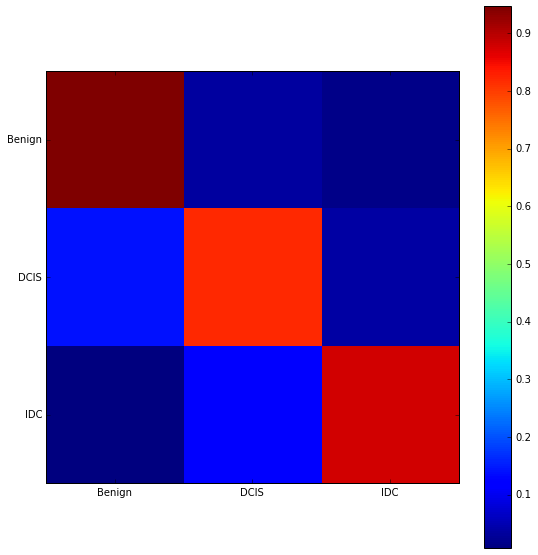

In [88]:
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(all_targets, all_binary_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label_names = ['Benign', 'DCIS', 'IDC']

plt.figure(figsize=(8,8))
plt.imshow(cm_normalized, interpolation='nearest')
plt.xticks(np.arange(0,3), label_names)
plt.yticks(np.arange(0,3), label_names)
plt.tight_layout()
plt.colorbar()
plt.show()


In [89]:
# From https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[7]) # 7 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}.3f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print 
    
print_cm(cm_normalized, label_names)

             Benign    DCIS     IDC
     Benign   0.947   0.035   0.019
       DCIS   0.140   0.820   0.040
        IDC   0.008   0.115   0.877
